<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Statistic/Python_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://reneshbedre.github.io/blog/anova.html

# One-way (one factor) ANOVA with Python

ANOVA Hypotheses

- Null hypotheses: Groups means are equal (no variation in means of groups)
- Alternative hypotheses: At least, one group mean is different from other groups

ANOVA Assumptions

- Residuals (experimental error) are normally distributed (Shapiro-Wilks Test)
- Homogeneity of variances (variances are equal between treatment groups) (Levene or Bartlett Test)
- Observations are sampled independently from each other

How ANOVA works?

- Check sample sizes: equal number of observation in each group
- Calculate Mean Square for each group (MS) (SS of group/level-1); level-1 is a degree of freedom (df) for a group
- Calculate Mean Square error (MSE) (SS error/df of residuals)
- Calculate F-value (MS of group/MSE)

In [2]:
# I am using Python 3
# load packages
import pandas as pd
# load data file
d = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/onewayanova.txt", sep="\t")
d

,A,B,C,D
0,25,45,30,54
1,30,55,29,60
2,28,29,33,51
3,36,56,37,62
4,29,40,27,73


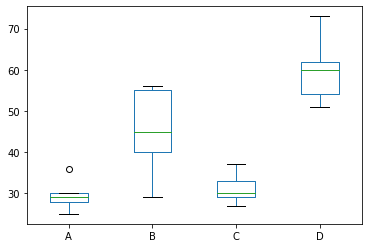

In [3]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can easily detect the differences 
# between different treatments
d.boxplot(column=['A', 'B', 'C', 'D'], grid=False)

In [4]:
# load packages
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(d['A'], d['B'], d['C'], d['D'])
print(fvalue, pvalue)

17.492810457516338 2.639241146210922e-05


In [8]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols
# reshape the d dataframe suitable for statsmodels package 
d_melt = pd.melt(d.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
# replace column names
d_melt.columns = ['index', 'treatments', 'value']
d_melt

,index,treatments,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29
5,0,B,45
6,1,B,55
7,2,B,29
8,3,B,56
9,4,B,40


In [9]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq    df         F    PR(>F)
C(treatments)  3010.95   3.0  17.49281  0.000026
Residual        918.00  16.0       NaN       NaN


In [7]:
# note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# (typ parameter) will produce similar results.

Interpretation: The P-value obtained from ANOVA analysis is significant (P<0.05), and therefore, we conclude that there are significant differences among treatments.

From ANOVA analysis, we know that treatment differences are statistically significant, but ANOVA does not tell which treatments are significantly different from each other. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey HSD test.

## Tukey HSD test

In [ ]:
#!pip install pingouin

In [16]:
# load packages
from pingouin import pairwise_tukey
# perform multiple pairwise comparison (Tukey HSD)
# for unbalanced (unequal sample size) data, pairwise_tukey uses Tukey-Kramer test
m_comp = pairwise_tukey(data=d_melt, dv='value', between='treatments')
m_comp

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.6,45.0,-15.4,4.790616,-3.214618,0.010718,-1.836351
1,A,C,29.6,31.2,-1.6,4.790616,-0.333986,0.900000,-0.190790
2,A,D,29.6,60.0,-30.4,4.790616,-6.345739,0.001000,-3.625005
3,B,C,45.0,31.2,13.8,4.790616,2.880632,0.027410,1.645561
4,B,D,45.0,60.0,-15.0,4.790616,-3.131121,0.013679,-1.788654
5,C,D,31.2,60.0,-28.8,4.790616,-6.011753,0.001000,-3.434215


In [ ]:
m_comp['Result']=m_comp['p-tukey'].apply(lambda x:)